<a href="https://colab.research.google.com/github/BhekiMabheka/Competitions/blob/master/zindi_sasol_competetion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description
The objective of this challenge is to create a machine-learning model that can forecast the probability of each customer becoming inactive and refraining from making any transactions for a period of 90 days.

An effective solution will enable a business to identify customers who may be on the verge of becoming inactive, allowing them to implement strategies in advance to retain these customers.

Sasol is looking for (2 senior, 1 principal) data scientists with experience in communicating their discoveries and methodology to the business. Solutions will be requested from the top 15 users in this challenge, and 10 users residing in South Africa will be invited for a job interview at Sasol. When submitting your solution, please include your up-to-date CV.

## Evaluation
The prize-winning submission is based on the following weightings: 60% F1 score, 20% approach & methodology, 20% verbal presentation.

The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

F1 Score: A performance score that combines both precision and recall. It is a harmonic mean of these two variables. Formula is given as: 2*Precision*Recall/(Precision + Recall)

Precision: This is an indicator of the number of items correctly identified as positive out of total items identified as positive. Formula is given as: TP/(TP+FP)

Recall / Sensitivity / True Positive Rate (TPR): This is an indicator of the number of items correctly identified as positive out of total actual positives. Formula is given as: TP/(TP+FN)

Where:

`TP=True Positive`
`FP=False Positive`
`TN=True Negative`
`FN=False Negative`

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
import xgboost as xgb
import warnings
from sklearn.metrics import accuracy_score

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data   = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/zindi_competetions/sasol_competetion/data/Train.csv")
test_data    = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/zindi_competetions/sasol_competetion/data/Test.csv")
variables_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/zindi_competetions/sasol_competetion/data/VariableDescription.csv")

In [4]:
train_data.sample(3)

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
631891,ID_E9NXNUDP7QR2,Stellaris,G 12-15 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
224938,ID_B5XLQ1B6WHET,NaN,G 12-15 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
834844,ID_4MGJZF27ZKIZ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,1


In [5]:
variables_df

,Variable Definitions,Unnamed: 2
0,NaN,The churn dataset includes 19 variables includ...
1,ID,NaN
2,region,the location of each client
3,tenure,duration in the network
4,Amount,top-up amount
5,refill_frequency,number of times the customer refilled
6,revenue,monthly revenue of each client
7,arpu_segment,revenue over 90 days / 3
8,frequency,number of times the client has made an revenue
9,data_volume,number of connections


---
#### Examine classes and class imbalance

Class imbalance means that there are unequal numbers of cases for the categories of the label. Class imbalance can seriously bias the training of classifier algorithms. It many cases, the imbalance leads to a higher error rate for the minority class. Most real-world classification problems have class imbalance, sometimes severe class imbalance, so it is important to test for this before training any model.

Class imbalance can be sovled by various sampling techniques such as [stratified sampling](https://https://en.wikipedia.org/wiki/Stratified_sampling), [Synthetic Minority Over-sampling](https://https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1), [SVMSMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SVMSMOTE.html#imblearn.over_sampling.SVMSMOTE) etc. Imbalance have a big impact on the model metric evaluation; more especially if you're trying to optimize accuracy!

---

In [6]:
normalized_counts = train_data['Target'].value_counts(normalize=True).round(2)
fig = px.bar(x=normalized_counts.index, y=normalized_counts.values,
             labels={'x': 'Target', 'y': 'Normalized Count'},
             title='Distribution of the Target Label',
             text=normalized_counts.values,
             color=normalized_counts.index,
             color_discrete_sequence=px.colors.qualitative.Set1,
             height=500,
             width=800)
fig.show()

### Checking Data


In [7]:
def plot_missing_values(dataframe):
    total_missing = dataframe.isnull().sum()
    percentage_missing = (total_missing / len(dataframe)) * 100
    missing_data = pd.concat([total_missing, percentage_missing], axis=1, keys=['Total Missing', 'Percentage'])
    missing_data = missing_data[missing_data['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

    if not missing_data.empty:
        fig = px.bar(missing_data, x=missing_data.index, y='Percentage',
                     labels={'x': 'Columns', 'y': 'Percentage of Missing Values'},
                     title='Percentage of Missing Values by Column',
                     color='Total Missing',
                     text=missing_data['Percentage'].round(2).astype(str) + '%',
                     height=500,
                     width=900)
        fig.show()
    else:
        print("No missing values in the DataFrame.")

In [8]:
plot_missing_values(train_data)

In [9]:
plot_missing_values(test_data)

## Visualize class separation by numeric features

The primary goal of visualization for classification problems is to understand which features are useful for class separation.

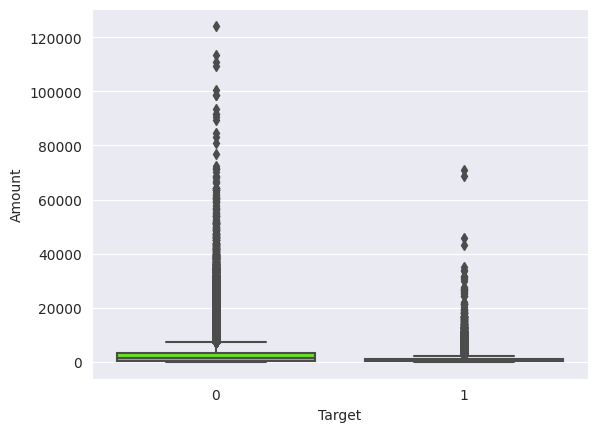

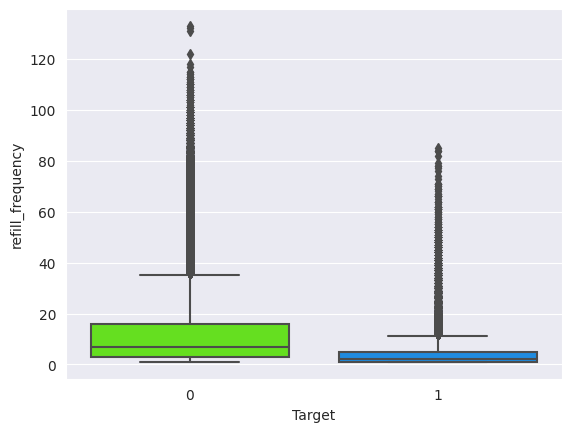

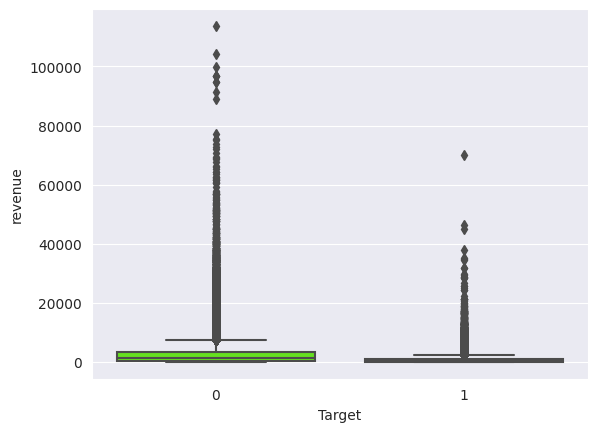

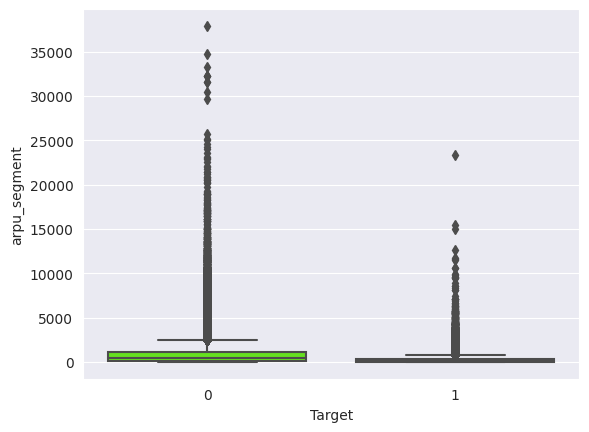

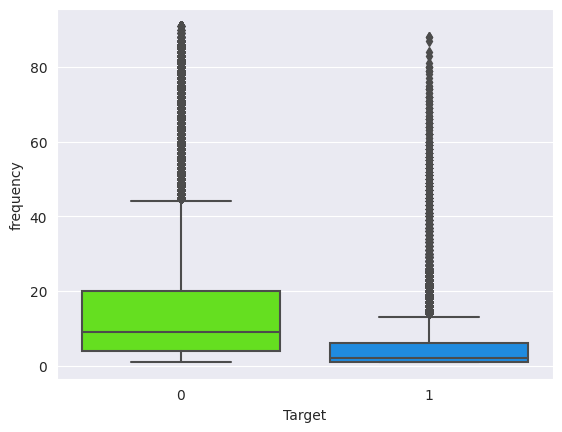

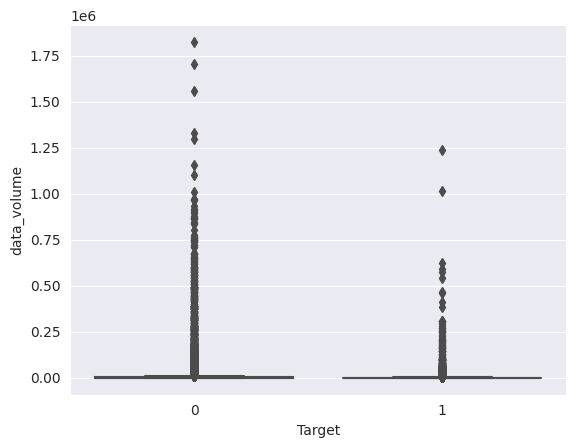

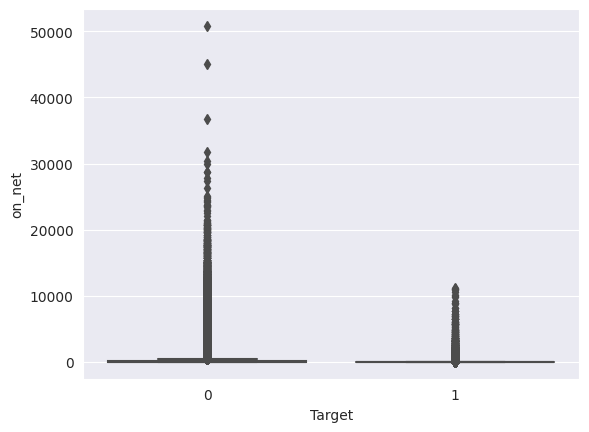

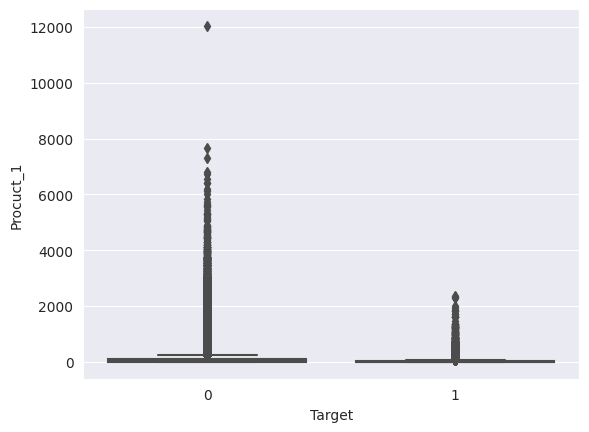

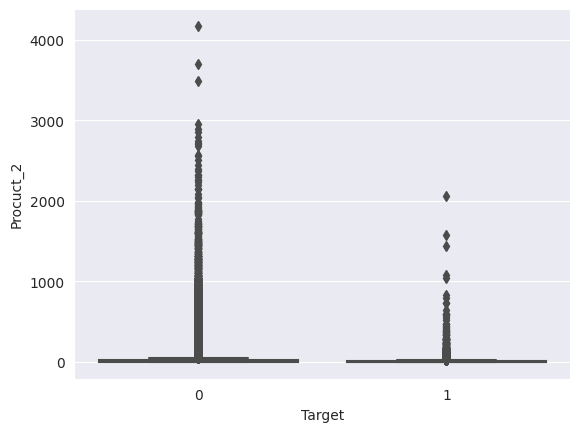

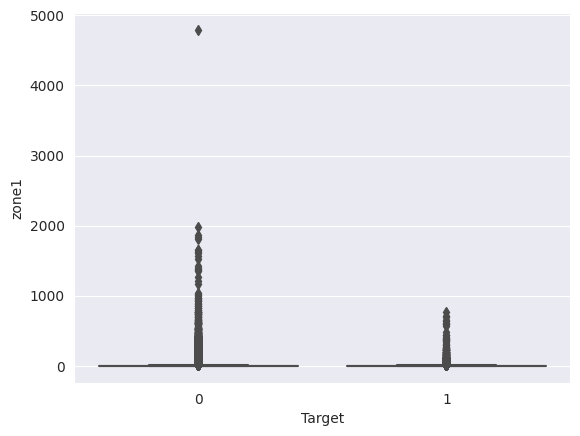

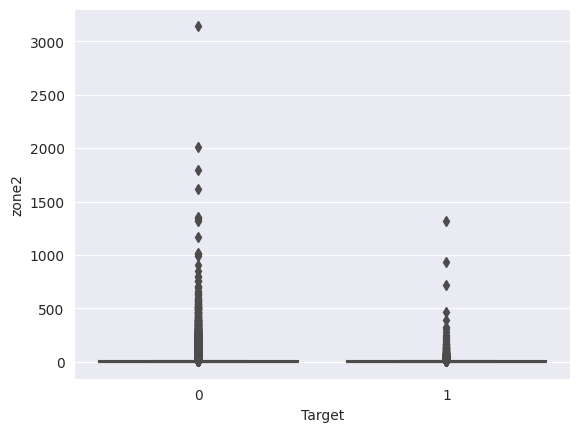

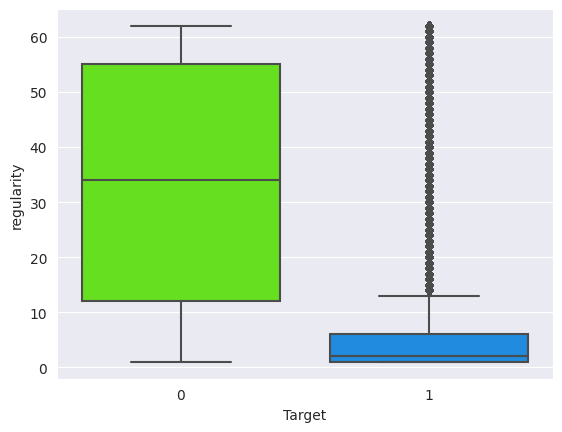

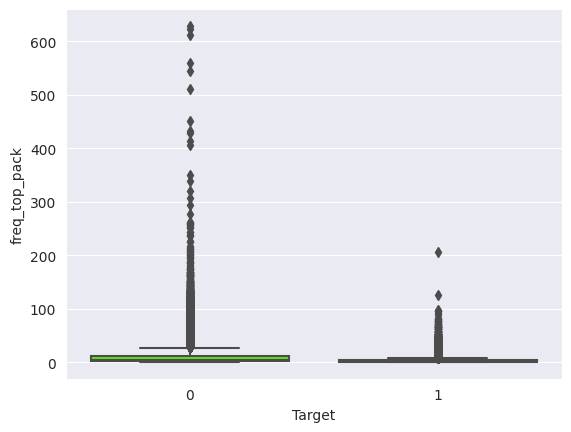

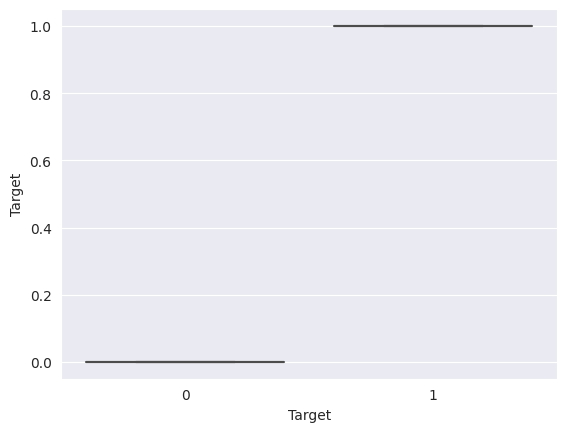

In [10]:
def boxplot(df, target_label):
    """
    df: Pandas DataFrame
    target_label: numpy ndarray or Pandas Series
    """
    sns.set_style("darkgrid")
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in num_cols:
        sns.boxplot(x=target_label, y=col, data=df, palette="gist_rainbow")
        plt.show()

boxplot(df=train_data, target_label="Target")

### Data Preprocessing

In [11]:
def preprocess_data(data):

    # Impute missing values for numeric features with the median
    numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].median())

    # Impute missing values for categorical features with the mode
    categorical_features = data.select_dtypes(include=['object']).columns
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    # Convert categorical features to numerical using one-hot encoding
    #data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

    # Feature engineering for 'tenure'
    # data['numeric_months'] = data['tenure'].str.extract('(\d+)', expand=False).astype(float)
    # data['time_category'] = data['tenure'].str.extract('([A-Z]+)', expand=False)

    # data['lower_bound'] = data['tenure'].str.extract('(\d+)')
    # data['lower_bound'] = pd.to_numeric(data['lower_bound'])

    # bins = [0, 6, 12, 18, 24, float('inf')]
    # labels = ['0-6 months', '6-12 months', '12-18 months', '18-24 months', '24+ months']

    # data['duration_bin'] = pd.cut(data['lower_bound'], bins=bins, labels=labels, right=False)

    # df_encoded = pd.get_dummies(data['duration_bin'], prefix='duration')
    # data = pd.concat([data, df_encoded], axis=1)

    return data

In [12]:
train_data = preprocess_data(data=train_data)
test_data = preprocess_data(data=test_data)

In [13]:
pd.set_option('display.max_colwidth', None)
def get_categorical_unique_values(data):
    """
    Get unique values for each categorical feature in a DataFrame.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with unique values and counts for each categorical feature.
    """

    # Select columns with object (string) data type
    categorical_features = data.select_dtypes(include='object').columns

    # Create a DataFrame to store unique values
    unique_values_df = pd.DataFrame(columns=['Feature', 'Unique_Values'])

    # Check unique values for each categorical feature
    for feature in categorical_features:
        unique_values = data[feature].unique()
        unique_values_df = unique_values_df.append({'Feature': feature, 'Unique_Values': unique_values}, ignore_index=True)

    return unique_values_df

# Example usage:
unique_values_train_data = get_categorical_unique_values(train_data)
unique_values_test_data = get_categorical_unique_values(train_data)
unique_values_train_data

,Feature,Unique_Values
0,ID,"[ID_YEB05X4KUGPQ, ID_Z9IQ9QH52KVN, ID_YZSU7B7M35QS, ID_QS4F5LEX29KM, ID_8IYIC9PFU8U1, ID_MJFIYBIBY0JO, ID_LRE4OJMM1T2C, ID_BY33YU074XLI, ID_GV22KJO949U2, ID_8EP70ZC40LKW, ID_VRMNAF2GPIES, ID_Z41ZFU3UXBJF, ID_5TCBKDX86125, ID_3A7XFFZCIMN3, ID_WIRHUQW52NTL, ID_5DHBHLVC4A9N, ID_YGHQ4WT3GZ61, ID_JL8BDJCUG70N, ID_FLWXNJ571AQJ, ID_KRTBDDDFMRIJ, ID_U3EQ7HL8RFHQ, ID_641DCPD4EHU1, ID_Z9CKKBN6PURY, ID_CDCV5Y6ZMSEJ, ID_GTFQTZXX7VVH, ID_5JFPSKFD72RQ, ID_2NYM6W7CTV18, ID_Z64QAQXAWK77, ID_B50IU9W41REY, ID_8ZMIETSU7FRG, ID_FFH6WQD837JG, ID_VXGGLWGONMW8, ID_Z82IGQHHST0A, ID_Q3C82CH19FCF, ID_P2DJDLRB7JV0, ID_J8AQ5NG1Y77B, ID_J24AE3QXYOFJ, ID_GAGY5TTMUQ1O, ID_MMARJFXR0GFB, ID_YIIFIYF8ML4Y, ID_4MA11HFEY77Q, ID_N8ZRA50H5UK1, ID_NVPZ41N9WUP2, ID_ETZTM1G3YBL4, ID_I3FGF32AK8MR, ID_9XRME44YUWYU, ID_ICC5DNZWTKTZ, ID_NFJSEJE5I2BF, ID_594TWQZSS6FH, ID_DVA0W9US4MC9, ID_8VJJPE3I8C4C, ID_NEN6NDIJ0DIA, ID_Y9HHY6YQQ639, ID_MP9DRDNPUB47, ID_1KA9MOH19IDM, ID_UUGHEM938J9E, ID_6FVDN50GRKUQ, ID_87ZQXSLE457L, ID_NU3U6ANK9DKL, ID_589OL92ZO0AP, ID_UR8F2UDJ4QHF, ID_0ZBEE4HFJDO1, ID_07WS4EPM65XU, ID_NFT68G3VUM7B, ID_FB1J64NXVDB4, ID_RTK7VKVMS3QP, ID_GBIX8Q48P1SE, ID_7UZ6XF8UDDCH, ID_HRUM2ATYEHXL, ID_9IQULPFG1E94, ID_X9KFGNXNU8N1, ID_GQQHQW0Q34TG, ID_NE6XTFX3LPAA, ID_OOU286019KIZ, ID_5O6H4E25EJI0, ID_HWVPCZV6BNSP, ID_XY2ARWFDGF61, ID_K94TGG96OZFT, ID_EDFGFLYIAH0G, ID_8Q4PPP7QIV16, ID_UAG69UJZ4A4P, ID_2O9EPSQT4XO1, ID_29A2U6V2SP9X, ID_AKDVJ8UQRC11, ID_ILRY9M72OWTV, ID_DEVHUO9TI5MD, ID_ORGPAOOWA50E, ID_1K7YXF1D5B7L, ID_73MDIR9WBESK, ID_ZQAWJ4I58X4C, ID_9DD469DW4YKB, ID_T8BDHQ138OGR, ID_P97E636CIMEA, ID_51JPYB6JXX16, ID_7MZLXYWH9SAY, ID_5484E4NQWBC7, ID_3W40WQOI94CN, ID_47NOCBR4MBYY, ID_62GH3BFETRDS, ID_1TAHY9T53UX1, ...]"
1,region,"[Mandalore, Nebula, Celestial, Eclipsara, Droidika, Luminous, Nebulith, Stellaris, Zodiacalia, Quasar, Radiantara, Astral, Forcehaven, Eternum]"
2,tenure,"[K > 24 month, I 18-21 month, H 15-18 month, F 9-12 month, G 12-15 month, E 6-9 month, J 21-24 month, D 3-6 month]"
3,mrg,[NO]
4,top_pack,"[All-net 500F=2000F;5d, On net 200F=Unlimited _call24H, Mixt 250F=Unlimited_call24H, All-net 500F =2000F_AllNet_Unlimited, IVR Echat_Daily_50F, Data:1000F=2GB,30d, On-net 1000F=10MilF;10d, Data:50F=30MB_24H, Data: 100 F=40MB,24H, Jokko_Daily, Data:200F=Unlimited,24H, MIXT: 200mnoff net _unl on net _5Go;30d, VAS(IVR_Radio_Daily), MIXT:500F= 2500F on net _2500F off net;2d, Data: 200 F=100MB,24H, Data:DailyCycle_Pilot_1.5GB, Data:490F=1GB,7d, On-net 500F_FNF;3d, Twter_U2opia_Monthly, On-net 200F=60mn;1d, On-net 500=4000,10d, Data:1000F=5GB,7d, Data:500F=2GB,24H, Twter_U2opia_Daily, Data:300F=100MB,2d, Data:1500F=3GB,30D, All-net 600F= 3000F ;5d, Jokko_Monthly, Data: 490F=Night,00H-08H, Staff_CPE_Rent, MIXT: 590F=02H_On-net_200SMS_200 Mo;24h\t\t, 200=Unlimited1Day, Data:3000F=10GB,30d, Twter_U2opia_Weekly, All-net 1000=5000;5d, Data:150F=SPPackage1,24H, MROMO_TIMWES_RENEW, CVM_on-net bundle 500=5000, All-net 500F=1250F_AllNet_1250_Onnet;48h, On net 200F= 3000F_10Mo ;24H, DataPack_Incoming, YMGX 100=1 hour FNF, 24H/1 month, SUPERMAGIK_5000, New_YAKALMA_4_ALL, Data:1500F=SPPackage1,30d, SUPERMAGIK_1000, MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t, IVR Echat_Weekly_200F, FNF2 ( JAPPANTE), Data:30Go_V 30_Days, All-net 300=600;2d, Data:700F=1.5GB,7d, Pilot_Youth1_290, All-net 1000F=(3000F On+3000F Off);5d, On-net 300F=1800F;3d, Pilot_Youth4_490, 500=Unlimited3Day, EVC_500=2000F, WIFI_Family_2MBPS, Jokko_promo, Data:700F=SPPackage1,7d, Facebook_MIX_2D, 200F=10mnOnNetValid1H, MROMO_TIMWES_OneDAY, Yewouleen_PKG, MIXT:10000F=10hAllnet_3Go_1h_Zone3;30d\t\t, Internat: 1000F_Zone_3;24h\t\t, MIXT: 500F=75(SMS, ONNET, Mo)_1000FAllNet;24h\t\t, All-net 500F=4000F ; 5d, Internat: 1000F_Zone_1;24H\t\t, MIXT: 4900F= 10H on net_1,5Go ;30d, All-net 5000= 20000off+20000on;30d, EVC_100Mo, On-net 2000f_One_Month_100H; 30d, Jokko_Weekly, CVM_200f=400MB, Mixt : 500F=2500Fonnet_2500Foffnet ;5d, TelmunCRBT_daily, VAS(IVR_Radio_Monthly), EVC_JOKKO30, MIXT:1000F=4

In [14]:
train_data.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,Mandalore,K > 24 month,1282.05,7.0,1282.05,427.35,9.0,256.0,27.0,29.0,6.0,1.0,2.0,NO,3,All-net 500F=2000F;5d,5.0,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,6.0,1.0,2.0,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,29.0,1.0,1.0,2.0,NO,61,All-net 500F=2000F;5d,5.0,0
3,ID_QS4F5LEX29KM,Mandalore,K > 24 month,1282.05,7.0,1282.05,427.35,9.0,256.0,27.0,29.0,6.0,1.0,2.0,NO,6,All-net 500F=2000F;5d,5.0,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,1.0,2.0,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


In [15]:
X = train_data.drop(['ID', 'region', 'tenure', 'top_pack','mrg', 'Target'], axis=1)
y = train_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# List of classifiers
classifiers = [
    XGBClassifier(random_state=42),
    RandomForestClassifier(class_weight = "balanced", random_state = 42),
    LogisticRegression(class_weight="balanced",random_state = 42),
    KNeighborsClassifier()
]

# Train and evaluate each classifier
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print results
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("="*45)

Model: XGBClassifier
Accuracy: 0.8654
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    245064
           1       0.67      0.55      0.61     56503

    accuracy                           0.87    301567
   macro avg       0.79      0.74      0.76    301567
weighted avg       0.86      0.87      0.86    301567

Model: RandomForestClassifier
Accuracy: 0.8271
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89    245064
           1       0.53      0.79      0.63     56503

    accuracy                           0.83    301567
   macro avg       0.74      0.81      0.76    301567
weighted avg       0.87      0.83      0.84    301567

Model: LogisticRegression
Accuracy: 0.8094
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87    245064
           1       0.49      0.81      0

In [22]:
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
y_pred = model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89    245064
           1       0.53      0.79      0.63     56503

    accuracy                           0.83    301567
   macro avg       0.74      0.81      0.76    301567
weighted avg       0.87      0.83      0.84    301567



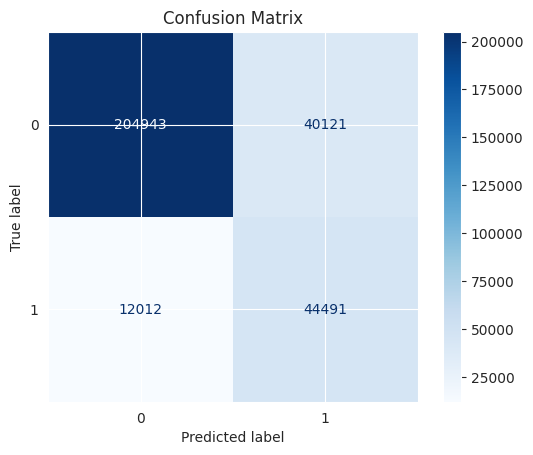

In [25]:
# Display confusion matrix using ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels = y.unique())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## Test Predictions

In [26]:
ids = test_data.ID
test_preds = model.predict(test_data.drop(['ID', 'region', 'tenure', 'top_pack','mrg'],
                                          axis = 1))
submt_pdf = pd.DataFrame({'ID': ids,
                          'Target': test_preds})
submt_pdf.to_csv("/content/drive/MyDrive/Colab Notebooks/zindi_competetions/sasol_competetion/data/submt_pdf.csv", index=False)

In [27]:
submt_pdf.sample(10)

,ID,Target
318598,ID_V3RB6ZX0RG5D,0
313432,ID_LYAP7005VY63,0
170465,ID_A8XY9O00TCIN,0
336518,ID_GOZ3HHTG7DUD,0
263759,ID_OEPQI9JAHDD1,1
339088,ID_02QJ22DYR5HP,1
60041,ID_QQCE2YJHS94P,0
223620,ID_KAY5FVEVK4LY,0
178913,ID_MUU36RJ29HDU,0
249102,ID_Q56RDF43BZQD,0
